In [7]:
import os

new_base_dir = "/root/XAI-for-ASD/" 

os.chdir(new_base_dir)

In [8]:
import argparse
import json
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import colormaps, colorbar
import collections
import numpy as np
import pandas as pd
import os
import networkx as nx
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import DataLoader, TensorDataset
from captum.attr import IntegratedGradients
from nilearn import datasets, plotting

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# ============================================================================
# Data Loading and Feature Extraction
# ============================================================================

def get_data_from_abide(pipeline):
  downloads = f'abide/downloads/Outputs/{pipeline}/filt_global/rois_aal/'
  pheno_file_path = 'data/Phenotypic_V1_0b_preprocessed1.csv'

  with open(pheno_file_path, 'r') as pheno_file:
    pheno_list = pheno_file.readlines()

  labels_dict = {}
  for i in pheno_list[1:]:
    file_name = i.split(',')[6]
    diagnosis = i.split(',')[7]
    labels_dict[file_name] = float(diagnosis)

  data = []
  labels = []

  for filename in sorted(os.listdir(downloads)):
    if filename.endswith('.1D'):
      filepath = os.path.join(downloads, filename)
      dataset = np.loadtxt(filepath)
      data.append(dataset)
      file_id = '_'.join(filename.split('_')[:-2])
      labels.append(labels_dict[file_id])

  labels = np.array(labels) - 1
  return data, labels

# ============================================================================
# Feature Extraction
# ============================================================================

def get_feature_vecs(data):
  roi_size = data[0].shape[1]
  feature_vecs = []
  feature_indices = []
  
  for i in range(len(data)):
    corr_coefs = np.corrcoef(data[i], rowvar=False)
    corr_coefs = np.nan_to_num(corr_coefs)
    
    # Apply Fisher Z-transform with clipping for numerical stability
    corr_coefs = np.clip(corr_coefs, -0.9999, 0.9999)
    transformed_corr_coefs = 0.5 * np.log((1 + corr_coefs) / (1 - corr_coefs))
    
    f = []
    idx = []
    lower_triangular_indices = np.tril_indices(transformed_corr_coefs.shape[0], -1)

    for row_idx, col_idx in zip(*lower_triangular_indices):
      coefficient = transformed_corr_coefs[row_idx, col_idx]
      f.append(coefficient)
      idx.append([row_idx, col_idx])

    feature_vecs.append(f)
    feature_indices.append(idx)

  feature_vecs = np.array(feature_vecs)
  feature_indices = np.array(feature_indices)
  return feature_vecs, feature_indices

# ============================================================================
# Feature Selection (RFE)
# ============================================================================

def fit_rfe_on_fold(X_train, y_train, X_val, X_test, N, step):
  """Fit RFE on training data only and apply to val/test data (prevents data leakage)."""
  svm = SVC(kernel="linear")
  rfe = RFE(estimator=svm, n_features_to_select=N, step=step, verbose=0)
  rfe.fit(X_train, y_train)
  X_train_selected = rfe.transform(X_train)
  X_val_selected = rfe.transform(X_val)
  X_test_selected = rfe.transform(X_test)
  return X_train_selected, X_val_selected, X_test_selected, rfe.support_

def fishers_z_transform(x):
  """Fisher's Z-transform for correlation coefficients with numerical stability."""
  # Clip to prevent inf values
  x = np.clip(x, -0.9999, 0.9999)
  return 0.5 * np.log((1 + x) / (1 - x))

def safe_divide(numerator, denominator):
  """Safely divide two numbers, avoiding division by zero."""
  return 0 if denominator == 0 else numerator / denominator

# ============================================================================
# Model Architecture
# ============================================================================

class Autoencoder(nn.Module):
  def __init__(self, input_size, encoded_output_size, rho=0.2, beta=2, criterion=nn.MSELoss()):
    """Sparse Autoencoder with KL divergence regularization."""
    super(Autoencoder, self).__init__()
    self.encoder = nn.Linear(input_size, encoded_output_size)
    self.decoder = nn.Linear(encoded_output_size, input_size)
    self.rho = rho
    self.beta = beta
    self.criterion = criterion
  
  def kl_divergence(self, rho, rho_hat):
    """Calculates KL divergence for sparsity regularization with numerical stability."""
    eps = 1e-10
    rho_hat = torch.clamp(rho_hat, eps, 1 - eps)
    return rho * torch.log(rho / (rho_hat + eps)) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat + eps))
  
  def forward(self, x):
    encoded = torch.relu(self.encoder(x))
    rho_hat = torch.mean(encoded, dim=0)
    kl_loss = self.kl_divergence(self.rho, rho_hat).sum()
    decoded = self.decoder(encoded)
    mse_loss = self.criterion(decoded, x)
    loss = mse_loss + self.beta * kl_loss
    return encoded, decoded, loss

class SoftmaxClassifier(nn.Module):
  def __init__(self, input_size, num_classes):
    super(SoftmaxClassifier, self).__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, x):
    return self.linear(x)

class StackedAutoencoder(nn.Module):
  def __init__(self, AE1, AE2, classifier):
    super(StackedAutoencoder, self).__init__()
    self.ae1 = AE1
    self.ae2 = AE2
    self.classifier = classifier

  def forward(self, x):
    x = self.ae1.encoder(x)
    x = self.ae2.encoder(x)
    x = self.classifier(x)
    return x
  
# ============================================================================
# Data Encoding and Loading
# ============================================================================ 


def get_encoded_data(model, dataloader, dataloader_params, device):
  """Encodes data using a given model and returns a DataLoader with encoded features."""
  model.eval()  # Set to evaluation mode
  encoded_features_from_model = []
  labels_from_model = []

  for batch in dataloader:
    data, labels = batch
    data = data.float().to(device)
    with torch.no_grad():
      encoded_features, _, __ = model(data)
      encoded_features_from_model.append(encoded_features)
      labels_from_model.append(labels)

  encoded_dataset_tensor = torch.cat(encoded_features_from_model, dim=0)
  labels_tensor = torch.cat(labels_from_model, dim=0)
  encoded_dataset = TensorDataset(encoded_dataset_tensor, labels_tensor)
  encoded_dataset_loader = DataLoader(encoded_dataset, **dataloader_params)
  model.train()  # Set back to training mode
  return encoded_dataset, encoded_dataset_loader



# ============================================================================
# Network Visualization Utilities
# ============================================================================

def get_threshold_from_percentile(adjacency_matrix, percentile):
  all_weights = adjacency_matrix[np.nonzero(adjacency_matrix)]
  threshold = np.percentile(all_weights, percentile)
  return threshold

def expand_relative_coords(coordinates, percent):
  """Scale coordinates relative to their center."""
  center = np.mean(coordinates, axis=0)
  centered_coordinates = coordinates - center
  scaled_coordinates = centered_coordinates * percent
  return scaled_coordinates + center


def print_connections(rois, weights, method, pipeline, top_regions=50, top_regions_df=10, show_now=False, save=False, print_graph=True):
  """Visualize brain network connections and ROI importance."""
  atlas = datasets.fetch_atlas_aal(version='SPM12')
  labels = atlas.labels
  weights = np.array(weights)
  rois = rois.astype(int)[:top_regions]
  weights = ((weights - weights.min()) / (weights.max() - weights.min())) * 10
  weights = weights[:top_regions]
  num_connections = len(rois)
  cmap = colormaps['viridis']

  if print_graph:
    fig = plt.figure(figsize=(15, 8))
    ax_connection_connectome = fig.add_axes([0.05, 0.55, 0.8, 0.40])
    ax_connection_colorbar = fig.add_axes([0.85, 0.55, 0.05, 0.40])
    ax_roi_connectome = fig.add_axes([0.05, 0.05, 0.8, 0.40])
    ax_roi_colorbar = fig.add_axes([0.85, 0.05, 0.05, 0.40])
    fig.suptitle(f'Top {num_connections} connections and ROI Importance using {method} for {pipeline}', fontsize=16)

  G = nx.Graph()
  for label in labels:
    G.add_node(label)

  for i, roi_pair in enumerate(rois):
    roi1_index = int(roi_pair[0])
    roi2_index = int(roi_pair[1])
    roi1_name = labels[roi1_index]
    roi2_name = labels[roi2_index]
    weight = weights[i]
    G.add_edge(roi1_name, roi2_name, weight=weight)

  coordinates = expand_relative_coords(plotting.find_parcellation_cut_coords(atlas.maps), 1.08)
  adjacency_matrix = nx.adjacency_matrix(G).todense()
  edge_threshold = get_threshold_from_percentile(adjacency_matrix, 0)

  if print_graph:
    plotting.plot_connectome(adjacency_matrix, coordinates,
                            node_color='grey',
                            edge_vmin=0,
                            edge_vmax=weights.max(),
                            edge_cmap=cmap,
                            edge_threshold=edge_threshold,
                            axes=ax_connection_connectome)
    norm = Normalize(vmin=weights.min(), vmax=weights.max())
    cb = colorbar.ColorbarBase(ax_connection_colorbar, cmap=cmap, norm=norm, orientation='vertical')
    cb.set_label('Importance')

  # Count the occurrence of each ROI
  all_rois = [int(roi) for pair in rois for roi in pair]
  roi_counts = collections.Counter(all_rois)
  top_rois, top_counts = zip(*roi_counts.most_common())

  adjacency_matrix = np.zeros((len(coordinates), len(coordinates)))
  roi_importances = []

  for idx, label in enumerate(labels):
    if idx in top_rois:
      i = top_rois.index(idx)
      possible_weights = []
      for j in range(len(rois)):
        if float(idx) in rois[j]:
          possible_weights.append(weights[j])
      weight = max(possible_weights) if possible_weights else 1
      roi_importances.append((top_counts[i]+1)*weight)
    else:
      roi_importances.append(0.0001)

  roi_importances = np.array(roi_importances)
  normalized_sizes = 20 + (roi_importances - roi_importances.min()) / (roi_importances.max() - roi_importances.min()) * 180
  normalized_colors = cmap((roi_importances - roi_importances.min()) / (roi_importances.max() - roi_importances.min()))

  if print_graph:
    plotting.plot_connectome(adjacency_matrix, coordinates,
                          node_color=normalized_colors,
                          node_size=normalized_sizes,
                          display_mode='ortho',
                          colorbar=False,
                          axes=ax_roi_connectome)
    norm = Normalize(vmin=roi_importances.min(), vmax=roi_importances.max())
    cb = colorbar.ColorbarBase(ax_roi_colorbar, cmap=cmap, norm=norm, orientation='vertical')
    cb.set_label('Importance')

    if save:
      filename = f"plots/{pipeline}/{pipeline}_plot_{method}_{num_connections}_connections.png"
      plt.savefig(filename)

    if show_now:
      plt.show()

  with open('aal_roi_functions.json', 'r') as file:
    ROI_functions = json.load(file)

  labels = np.array(atlas.labels)
  top_connections = labels[rois[:top_regions_df]]
  connections_with_weights = np.array([(connection[0], ROI_functions[connection[0]], connection[1], ROI_functions[connection[1]], np.round(weight, 2)) 
                                        for connection, weight in zip(top_connections, weights)])
  top_connections_df = pd.DataFrame(connections_with_weights, columns=['ROI 1', 'ROI 1 function', 'ROI 2', 'ROI 2 function', 'Importance'])

  important_rois = np.argsort(roi_importances)[::-1]
  important_rois_weights = roi_importances[important_rois]
  important_rois_weights = 10 * ((important_rois_weights - important_rois_weights.min()) / (important_rois_weights.max() - important_rois_weights.min()))
  important_rois_with_weights = np.array([(labels[roi], ROI_functions[labels[roi]], np.round(weight, 2)) 
                                           for roi, weight in zip(important_rois, important_rois_weights)])
  top_rois_df = pd.DataFrame(important_rois_with_weights[:top_regions_df], columns=['ROI', 'Function', 'Importance'])

  return top_connections_df, top_rois_df

# ============================================================================
# Early Stopping Utility
# ============================================================================

class EarlyStopping:
  """Early stopping to stop training when validation loss doesn't improve."""
  def __init__(self, patience=10, min_delta=0, verbose=False):
    self.patience = patience
    self.min_delta = min_delta
    self.verbose = verbose
    self.counter = 0
    self.best_loss = None
    self.early_stop = False
    self.best_model_state = None
    
  def __call__(self, val_loss, model):
    if self.best_loss is None:
      self.best_loss = val_loss
      self.best_model_state = model.state_dict().copy()
    elif val_loss > self.best_loss - self.min_delta:
      self.counter += 1
      if self.verbose:
        print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
        self.early_stop = True
    else:
      self.best_loss = val_loss
      self.best_model_state = model.state_dict().copy()
      self.counter = 0
    
    return self.early_stop

# ============================================================================
# Model Training and Evaluation
# ============================================================================

def train_and_eval_model(data, labels_from_abide, pipeline, verbose=False, train_model=True, save_model=False, rfe_step=1):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
  avg_TP, avg_FP, avg_FN, avg_TN = [], [], [], []
  fold_accuracies = []
  fold_sensitivities = []
  fold_specificities = []
  fold_precisions = []
  fold_f1_scores = []

  fold = 0
  # Convert data to list if it's an array
  data_list = list(data) if not isinstance(data, list) else data
  
  for train_idx, test_idx in skf.split(data_list, labels_from_abide):
    fold += 1

    if verbose:
      print(f'======================================\nSplit {fold}\n======================================')

    # Extract train and test data separately
    train_data = [data_list[i] for i in train_idx]
    test_data = [data_list[i] for i in test_idx]
    
    # Extract features separately for train and test (prevents data leakage)
    train_feature_vecs, train_feature_indices = get_feature_vecs(train_data)
    test_feature_vecs, _ = get_feature_vecs(test_data)
    
    # Split training features into train and validation (increased to 15%)
    train_subidx, val_subidx = train_test_split(range(len(train_feature_vecs)), test_size=0.15, random_state=seed)
    X_train = train_feature_vecs[train_subidx]
    y_train = labels_from_abide[train_idx][train_subidx]
    X_val = train_feature_vecs[val_subidx]
    y_val = labels_from_abide[train_idx][val_subidx]
    X_test = test_feature_vecs
    y_test = labels_from_abide[test_idx]
    
    X_train_selected, X_val_selected, X_test_selected, support_mask = fit_rfe_on_fold(
      X_train, y_train, X_val, X_test, N=1000, step=rfe_step
    )
    
    if verbose:
      print(f"RFE selected {np.sum(support_mask)} features out of {len(support_mask)}")
      print("Total: ", len(train_feature_vecs) + len(test_feature_vecs))
      print("Train: ", len(X_train_selected))
      print("Test: ", len(X_test_selected))
      print("Validation: ", len(X_val_selected)) 

    # Create TensorDatasets
    train_set = TensorDataset(torch.from_numpy(X_train_selected).float(), torch.from_numpy(y_train).long())
    test_set = TensorDataset(torch.from_numpy(X_test_selected).float(), torch.from_numpy(y_test).long())
    val_set = TensorDataset(torch.from_numpy(X_val_selected).float(), torch.from_numpy(y_val).long())

    params = {
      'batch_size': 128,
      'shuffle': True,
      'num_workers': 0
    }

    val_params = {
      'batch_size': 128,
      'shuffle': False,
      'num_workers': 0
    }

    test_params = {
      'batch_size': 128,
      'shuffle': False,
      'num_workers': 0
    }
    
    train_dataloader = DataLoader(train_set, **params)
    test_dataloader = DataLoader(test_set, **test_params)
    val_dataloader = DataLoader(val_set, **val_params)

    AE1 = Autoencoder(1000, 500).to(device)
    AE2 = Autoencoder(500, 100).to(device)
    classifier = SoftmaxClassifier(100, 2).to(device)
    model = StackedAutoencoder(AE1, AE2, classifier).to(device)

    if (train_model):
      AE1_epochs = 100  # Increased max epochs since we have early stopping
      optimizer_ae1 = optim.Adam(AE1.parameters(), lr=0.001, weight_decay=1e-4)
      early_stopping_ae1 = EarlyStopping(patience=10, verbose=verbose)
      
      AE2_epochs = 100
      optimizer_ae2 = optim.Adam(AE2.parameters(), lr=0.001, weight_decay=1e-4)
      early_stopping_ae2 = EarlyStopping(patience=10, verbose=verbose)

      classifier_epochs = 400
      optimizer_classifier = optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-4)
      early_stopping_classifier = EarlyStopping(patience=15, verbose=verbose)

      optimizer = optim.Adam(model.parameters(), lr=0.0001)
      early_stopping_model = EarlyStopping(patience=15, verbose=verbose)

      ae_criterion = nn.MSELoss()
      classifier_criterion = nn.CrossEntropyLoss()

      fine_tuning_epochs = 200

      loss_ae1 = []
      val_ae1 = []

      # Train AE1 with early stopping
      for epoch in range(AE1_epochs):
        AE1.train()
        for batch in train_dataloader:
          data, labels = batch
          data = data.float().to(device)

          optimizer_ae1.zero_grad()
          encoded_features, decoded_featues, loss = AE1(data)
          loss.backward()
          optimizer_ae1.step()
        loss_ae1.append(loss.item())

        # Validation with eval mode
        AE1.eval()
        val_loss = 0.0
        with torch.no_grad():
          for batch in val_dataloader:
            data, labels = batch
            data = data.float().to(device)
            encoded_features, decoded_featues, loss = AE1(data)
            val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_ae1.append(val_loss)

        if verbose:
          print(f"AE 1: Epoch {epoch}, loss {loss_ae1[-1]:.4f}, validation loss {val_loss:.4f}")
        
        # Early stopping check
        if early_stopping_ae1(val_loss, AE1):
          if verbose:
            print(f"Early stopping triggered at epoch {epoch}")
          AE1.load_state_dict(early_stopping_ae1.best_model_state)
          break
      
      if verbose:
        print("======================================\nTrained AE 1\n======================================")

      encoded_dataset, encoded_dataset_loader = get_encoded_data(AE1, train_dataloader, params, device)
      val_encoded_dataset, val_encoded_dataset_loader = get_encoded_data(AE1, val_dataloader, val_params, device)

      loss_ae2 = []
      val_ae2 = []

      # Train AE2 with early stopping
      for epoch in range(AE2_epochs):
        AE2.train()
        for batch in encoded_dataset_loader:
          data, labels = batch
          data = data.float().to(device)

          optimizer_ae2.zero_grad()
          encoded_features, decoded_featues, loss = AE2(data)
          loss.backward()
          optimizer_ae2.step()
        loss_ae2.append(loss.item())

        # Validation with eval mode
        AE2.eval()
        val_loss = 0.0
        with torch.no_grad():
          for batch in val_encoded_dataset_loader:
            data, labels = batch
            data = data.float().to(device)
            encoded_features, decoded_featues, loss = AE2(data)
            val_loss += loss.item()

        val_loss /= len(val_encoded_dataset_loader)
        val_ae2.append(val_loss)

        if verbose:
          print(f"AE 2: Epoch {epoch}, loss {loss_ae2[-1]:.4f}, validation loss {val_loss:.4f}")
        
        # Early stopping check
        if early_stopping_ae2(val_loss, AE2):
          if verbose:
            print(f"Early stopping triggered at epoch {epoch}")
          AE2.load_state_dict(early_stopping_ae2.best_model_state)
          break

      if verbose:
        print("======================================\nTrained AE 2\n======================================")

      encoded_dataset, encoded_dataset_loader = get_encoded_data(AE2, encoded_dataset_loader, params, device)
      val_encoded_dataset, val_encoded_dataset_loader = get_encoded_data(AE2, val_encoded_dataset_loader, val_params, device)

      loss_classifier = []
      val_classifier = []

      # Train classifier with early stopping
      for epoch in range(classifier_epochs):
        classifier.train()
        for batch in encoded_dataset_loader:
          data, labels = batch
          data = data.float().to(device)
          labels = labels.long().to(device)

          optimizer_classifier.zero_grad()
          classifier_output = classifier(data)
          loss = classifier_criterion(classifier_output, labels)
          loss.backward()
          optimizer_classifier.step()

        loss_classifier.append(loss.item())

        # Validation with eval mode
        classifier.eval()
        val_loss = 0.0
        with torch.no_grad():
          for batch in val_encoded_dataset_loader:
            data, labels = batch
            data = data.float().to(device)
            labels = labels.long().to(device)

            classifier_output = classifier(data)
            loss = classifier_criterion(classifier_output, labels)
            val_loss += loss.item()

        val_loss /= len(val_encoded_dataset_loader)
        val_classifier.append(val_loss)

        if verbose:
          print(f"Classifier: Epoch {epoch}, loss {loss_classifier[-1]:.4f}, validation loss {val_loss:.4f}")
        
        # Early stopping check
        if early_stopping_classifier(val_loss, classifier):
          if verbose:
            print(f"Early stopping triggered at epoch {epoch}")
          classifier.load_state_dict(early_stopping_classifier.best_model_state)
          break

      if verbose:
        print("======================================\nTrained classifier\n======================================")

      loss_model = []
      accuracy_model = []
      val_model = []
      val_accuracy_model = []
      
      # Fine-tune full model with early stopping
      for epoch in range(fine_tuning_epochs):
        model.train()
        total = 0
        correct = 0
        for batch in train_dataloader:
          data, labels = batch
          data = data.float().to(device)
          labels = labels.long().to(device)

          optimizer.zero_grad()
          outputs = model(data)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          loss = classifier_criterion(outputs, labels)
          loss.backward()
          optimizer.step()
        loss_model.append(loss.item())
        accuracy_model.append(100 * correct / total)

        # Validation with eval mode
        model.eval()
        val_loss = 0.0
        val_total = 0
        val_correct = 0
        with torch.no_grad():
          for batch in val_dataloader:
            data, labels = batch
            data = data.float().to(device)
            labels = labels.long().to(device)

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            loss = classifier_criterion(outputs, labels)

            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item()

        val_accuracy_model.append(100 * val_correct / val_total)
        val_loss /= len(val_dataloader)
        val_model.append(val_loss)

        if verbose:
          print(f"Model: Epoch {epoch}, loss {loss_model[-1]:.4f}, val loss {val_loss:.4f}, train acc {accuracy_model[-1]:.2f}%, val acc {val_accuracy_model[-1]:.2f}%")
        
        # Early stopping check
        if early_stopping_model(val_loss, model):
          if verbose:
            print(f"Early stopping triggered at epoch {epoch}")
          model.load_state_dict(early_stopping_model.best_model_state)
          break
      
      if verbose:
        print("======================================\nFine tuned model\n======================================")

        fig, axs = plt.subplots(1, 5, figsize=(20, 4))
        
        # Plot for AE1
        axs[0].plot(range(len(loss_ae1)), loss_ae1, label='Training Loss')
        axs[0].plot(range(len(val_ae1)), val_ae1, label='Validation Loss')
        axs[0].set_title('AE1 Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[0].grid(True, alpha=0.3)

        # Plot for AE2
        axs[1].plot(range(len(loss_ae2)), loss_ae2, label='Training Loss')
        axs[1].plot(range(len(val_ae2)), val_ae2, label='Validation Loss')
        axs[1].set_title('AE2 Loss')
        axs[1].set_xlabel('Epoch')
        axs[1].legend()
        axs[1].grid(True, alpha=0.3)

        # Plot for classifier
        axs[2].plot(range(len(loss_classifier)), loss_classifier, label='Training Loss')
        axs[2].plot(range(len(val_classifier)), val_classifier, label='Validation Loss')
        axs[2].set_title('Classifier Loss')
        axs[2].set_xlabel('Epoch')
        axs[2].legend()
        axs[2].grid(True, alpha=0.3)

        # Plot for Model
        axs[3].plot(range(len(loss_model)), loss_model, label='Training Loss')
        axs[3].plot(range(len(val_model)), val_model, label='Validation Loss')
        axs[3].set_title('Model Loss')
        axs[3].set_xlabel('Epoch')
        axs[3].legend()
        axs[3].grid(True, alpha=0.3)

        # Plot for Accuracy over fine tuning
        axs[4].plot(range(len(accuracy_model)), accuracy_model, label='Training Accuracy')
        axs[4].plot(range(len(val_accuracy_model)), val_accuracy_model, label='Validation Accuracy')
        axs[4].set_title('Accuracy')
        axs[4].set_xlabel('Epoch')
        axs[4].set_ylabel('Accuracy (%)')
        axs[4].legend()
        axs[4].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

      if save_model:
        torch.save(model.state_dict(), f'models/model_{pipeline}_fold{fold}_step{rfe_step}.pth')
    else:
      model.load_state_dict(torch.load(f'models/model_{pipeline}_fold{fold}_step{rfe_step}.pth', map_location=torch.device(device)))

    if verbose:
      print("======================================\nTesting Model\n======================================")

    model.eval()

    true_labels = np.array([])
    predicted_labels = np.array([])

    with torch.no_grad():
      for batch in test_dataloader:
        data, labels = batch
        data = data.float().to(device)
        labels = labels.long().to(device)

        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)

        true_labels = np.concatenate((true_labels, labels.cpu().numpy()), axis=0)
        predicted_labels = np.concatenate((predicted_labels, predicted.cpu().numpy()), axis=0)

    TP, FP, TN, FN = 0, 0, 0, 0

    for true_label, predicted_label in zip(true_labels, predicted_labels):
      if true_label == predicted_label == 0:
          TP += 1  # True Positive (correctly identified control)
      elif true_label == predicted_label == 1:
          TN += 1  # True Negative (correctly identified ASD)
      elif true_label == 1 and predicted_label == 0:
          FN += 1  # False Negative
      elif true_label == 0 and predicted_label == 1:
          FP += 1  # False Positive
    
    avg_TP.append(TP)
    avg_FP.append(FP)
    avg_FN.append(FN)
    avg_TN.append(TN)

    accuracy = safe_divide(TP + TN, TP + TN + FP + FN)
    sensitivity = safe_divide(TP, TP + FN)
    specificity = safe_divide(TN, TN + FP)
    precision = safe_divide(TP, TP + FP)
    f1 = safe_divide((2 * precision * sensitivity), (precision + sensitivity))
    
    fold_accuracies.append(accuracy)
    fold_sensitivities.append(sensitivity)
    fold_specificities.append(specificity)
    fold_precisions.append(precision)
    fold_f1_scores.append(f1)
    
    cm = np.array([[TP, FP], [FN, TN]])

    if verbose:
      print(f'Fold {fold} Results:')
      print(f'Accuracy: {(accuracy * 100):.2f}%')
      print(f'Sensitivity: {sensitivity:.4f}')
      print(f'Specificity: {specificity:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'F1_Score: {f1:.4f}')
      print(f'Confusion Matrix:\n{cm}')
  
  if verbose:
    print("======================================\nCompleted All Folds\n======================================")
  
  # Calculate averages
  TP = sum(avg_TP) / len(avg_TP)
  FP = sum(avg_FP) / len(avg_FP)
  FN = sum(avg_FN) / len(avg_FN)
  TN = sum(avg_TN) / len(avg_TN)

  accuracy = safe_divide(TP + TN, TP + TN + FP + FN)
  sensitivity = safe_divide(TP, TP + FN)
  specificity = safe_divide(TN, TN + FP)
  precision = safe_divide(TP, TP + FP)
  f1 = safe_divide((2 * precision * sensitivity), (precision + sensitivity))
  cm = np.array([[TP, FP], [FN, TN]])

  # Print results with confidence intervals
  print("\n" + "="*60)
  print("FINAL CROSS-VALIDATION RESULTS (Mean ± Std)")
  print("="*60)
  print(f'Accuracy:    {np.mean(fold_accuracies)*100:.2f}% ± {np.std(fold_accuracies)*100:.2f}%')
  print(f'Sensitivity: {np.mean(fold_sensitivities):.4f} ± {np.std(fold_sensitivities):.4f}')
  print(f'Specificity: {np.mean(fold_specificities):.4f} ± {np.std(fold_specificities):.4f}')
  print(f'Precision:   {np.mean(fold_precisions):.4f} ± {np.std(fold_precisions):.4f}')
  print(f'F1 Score:    {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}')
  print(f'\nAverage Confusion Matrix:\n{cm}')
  print("="*60)

  return model, accuracy, train_dataloader, test_dataloader



In [9]:
verbose = True
train_model = True
save_model = False
interpretation_methods = True
analyze_methods = True

verbose: True
train_model: True
save_model: False
Torch CUDA is available: True
Total samples loaded: 1035
Shape of raw data[0] (time points x ROIs): (236, 116)
Split 1


/usr/local/lib/python3.12/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


RFE selected 1000 features out of 6670
Total:  1035
Train:  703
Test:  207
Validation:  125
AE 1: Epoch 0, loss 36.4211, validation loss 47.3718
AE 1: Epoch 1, loss 21.0790, validation loss 16.0222
AE 1: Epoch 2, loss 10.5319, validation loss 10.4349
AE 1: Epoch 3, loss 7.0055, validation loss 5.3297
AE 1: Epoch 4, loss 4.7516, validation loss 4.4760
AE 1: Epoch 5, loss 2.9086, validation loss 2.1410
AE 1: Epoch 6, loss 2.2602, validation loss 1.8570
AE 1: Epoch 7, loss 2.4756, validation loss 1.3885
AE 1: Epoch 8, loss 2.1242, validation loss 1.2194
AE 1: Epoch 9, loss 1.8020, validation loss 1.1208
AE 1: Epoch 10, loss 1.6418, validation loss 1.1125
AE 1: Epoch 11, loss 1.2804, validation loss 0.9012
AE 1: Epoch 12, loss 1.7334, validation loss 1.0264
EarlyStopping counter: 1 out of 10
AE 1: Epoch 13, loss 1.2061, validation loss 1.0295
EarlyStopping counter: 2 out of 10
AE 1: Epoch 14, loss 1.2058, validation loss 0.8263
AE 1: Epoch 15, loss 1.1890, validation loss 1.2706
EarlyStopp

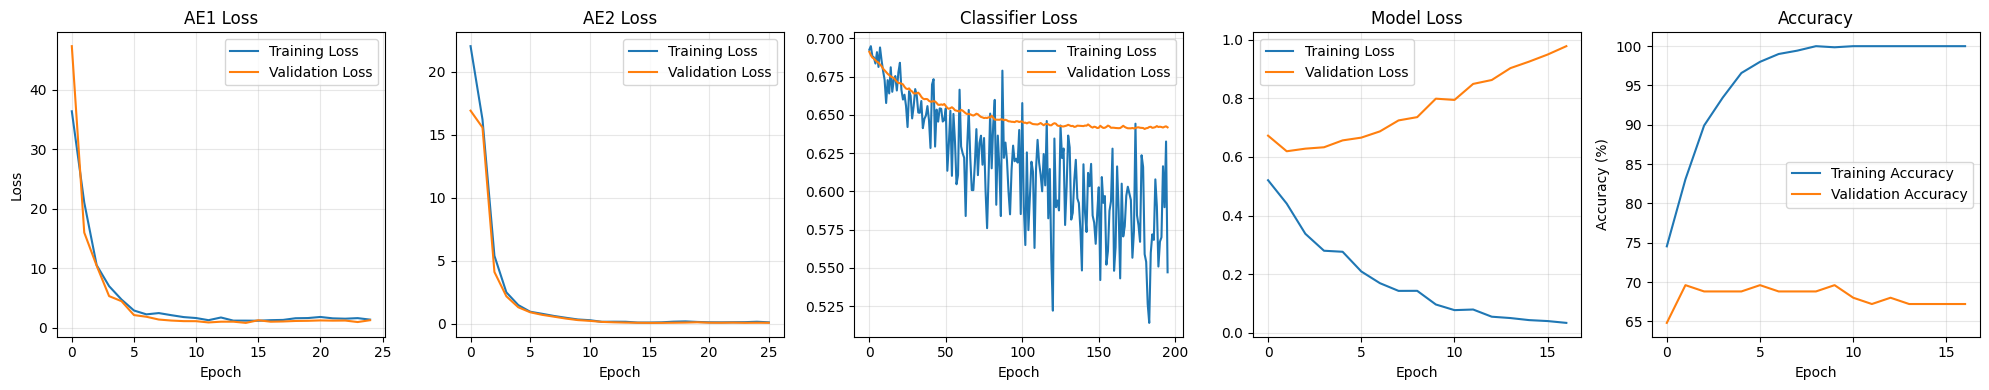

Testing Model
Fold 1 Results:
Accuracy: 62.32%
Sensitivity: 0.6095
Specificity: 0.6373
Precision: 0.6337
F1_Score: 0.6214
Confusion Matrix:
[[64 37]
 [41 65]]
Split 2


/usr/local/lib/python3.12/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


RFE selected 1000 features out of 6670
Total:  1035
Train:  703
Test:  207
Validation:  125
AE 1: Epoch 0, loss 53.1140, validation loss 50.6061
AE 1: Epoch 1, loss 21.0824, validation loss 17.4414
AE 1: Epoch 2, loss 11.3054, validation loss 9.7334
AE 1: Epoch 3, loss 6.6897, validation loss 6.5766
AE 1: Epoch 4, loss 4.2354, validation loss 4.0722
AE 1: Epoch 5, loss 3.1858, validation loss 2.2005
AE 1: Epoch 6, loss 2.5357, validation loss 1.7943
AE 1: Epoch 7, loss 2.2277, validation loss 1.3242
AE 1: Epoch 8, loss 1.7466, validation loss 1.2529
AE 1: Epoch 9, loss 1.4993, validation loss 1.2002
AE 1: Epoch 10, loss 1.3714, validation loss 0.9291
AE 1: Epoch 11, loss 1.7992, validation loss 1.1935
EarlyStopping counter: 1 out of 10
AE 1: Epoch 12, loss 1.6651, validation loss 0.8935
AE 1: Epoch 13, loss 1.3569, validation loss 0.9428
EarlyStopping counter: 1 out of 10
AE 1: Epoch 14, loss 1.3809, validation loss 0.9745
EarlyStopping counter: 2 out of 10
AE 1: Epoch 15, loss 1.4788,

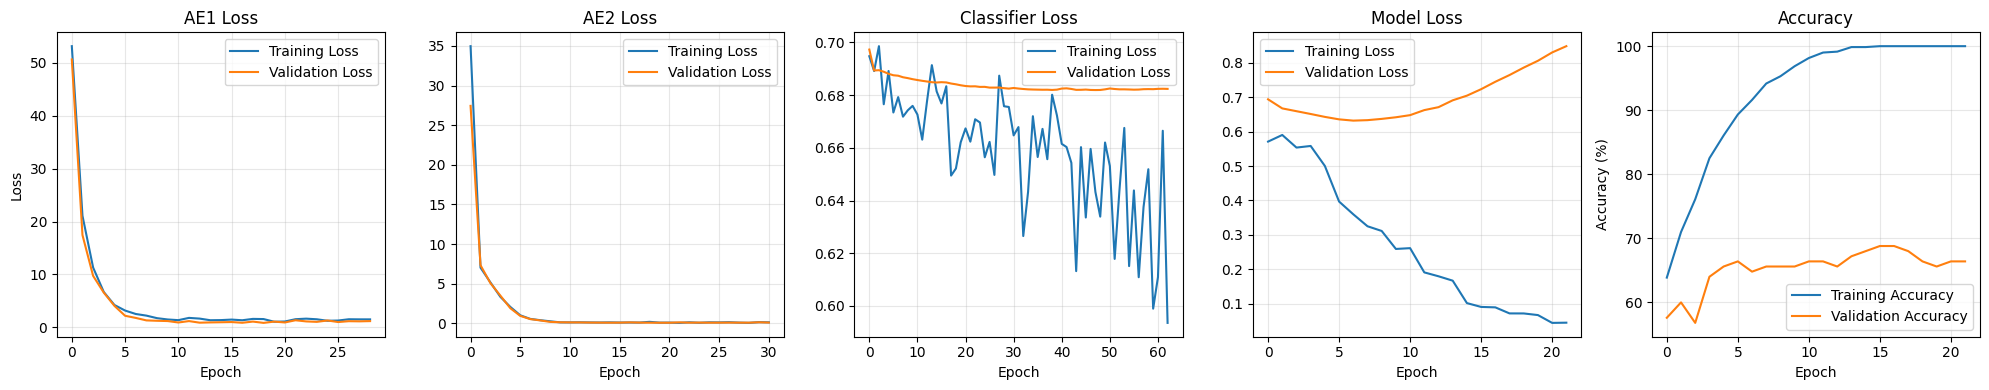

Testing Model
Fold 2 Results:
Accuracy: 65.70%
Sensitivity: 0.6531
Specificity: 0.6606
Precision: 0.6337
F1_Score: 0.6432
Confusion Matrix:
[[64 37]
 [34 72]]
Split 3


/usr/local/lib/python3.12/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


RFE selected 1000 features out of 6670
Total:  1035
Train:  703
Test:  207
Validation:  125
AE 1: Epoch 0, loss 49.0009, validation loss 56.1447
AE 1: Epoch 1, loss 25.7839, validation loss 23.7799
AE 1: Epoch 2, loss 13.2009, validation loss 11.7190
AE 1: Epoch 3, loss 7.0450, validation loss 5.6313
AE 1: Epoch 4, loss 4.1240, validation loss 4.0636
AE 1: Epoch 5, loss 2.9769, validation loss 2.7299
AE 1: Epoch 6, loss 2.6540, validation loss 1.8930
AE 1: Epoch 7, loss 1.8506, validation loss 1.6638
AE 1: Epoch 8, loss 2.0898, validation loss 1.2925
AE 1: Epoch 9, loss 1.5823, validation loss 1.3006
EarlyStopping counter: 1 out of 10
AE 1: Epoch 10, loss 1.9576, validation loss 1.1788
AE 1: Epoch 11, loss 1.4970, validation loss 1.3877
EarlyStopping counter: 1 out of 10
AE 1: Epoch 12, loss 1.2787, validation loss 1.3355
EarlyStopping counter: 2 out of 10
AE 1: Epoch 13, loss 1.4697, validation loss 1.0772
AE 1: Epoch 14, loss 1.4083, validation loss 1.3669
EarlyStopping counter: 1 ou

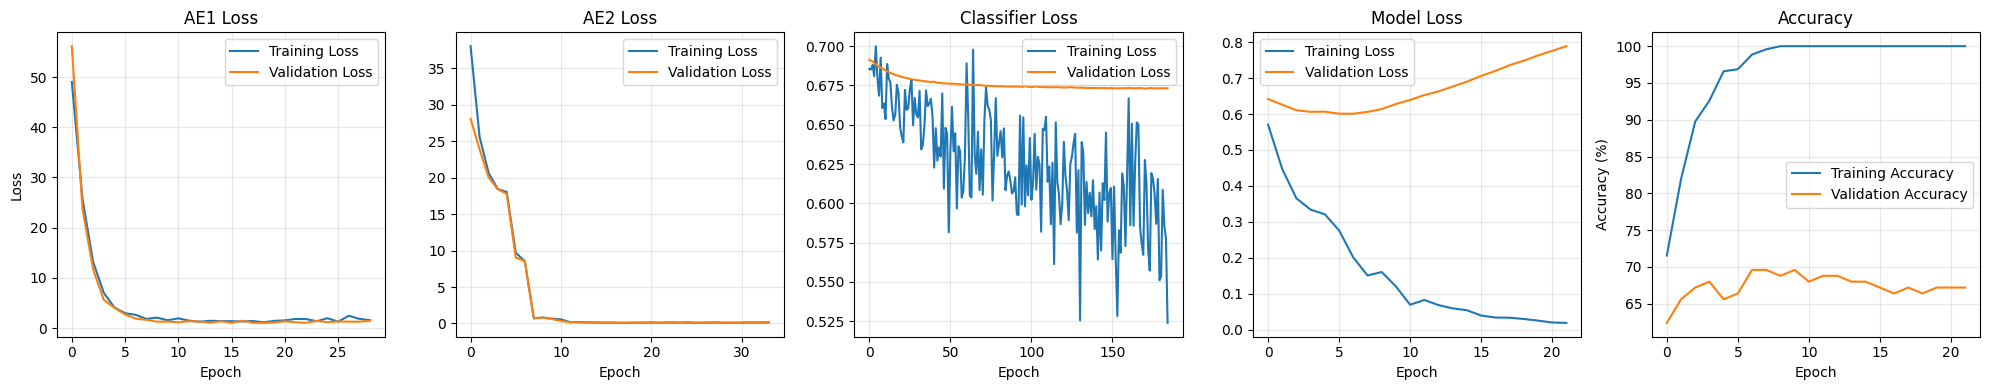

Testing Model
Fold 3 Results:
Accuracy: 63.77%
Sensitivity: 0.6327
Specificity: 0.6422
Precision: 0.6139
F1_Score: 0.6231
Confusion Matrix:
[[62 39]
 [36 70]]
Split 4


/usr/local/lib/python3.12/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


RFE selected 1000 features out of 6670
Total:  1035
Train:  703
Test:  207
Validation:  125
AE 1: Epoch 0, loss 44.7332, validation loss 50.6928
AE 1: Epoch 1, loss 21.8285, validation loss 17.0839
AE 1: Epoch 2, loss 12.8526, validation loss 12.0114
AE 1: Epoch 3, loss 7.0365, validation loss 6.5649
AE 1: Epoch 4, loss 4.9470, validation loss 4.0038
AE 1: Epoch 5, loss 3.1749, validation loss 2.4080
AE 1: Epoch 6, loss 2.2660, validation loss 1.8864
AE 1: Epoch 7, loss 2.4087, validation loss 1.4473
AE 1: Epoch 8, loss 1.7623, validation loss 1.1159
AE 1: Epoch 9, loss 1.3213, validation loss 1.1360
EarlyStopping counter: 1 out of 10
AE 1: Epoch 10, loss 1.3956, validation loss 0.9794
AE 1: Epoch 11, loss 1.5536, validation loss 0.8266
AE 1: Epoch 12, loss 1.5110, validation loss 1.0199
EarlyStopping counter: 1 out of 10
AE 1: Epoch 13, loss 1.2378, validation loss 0.8994
EarlyStopping counter: 2 out of 10
AE 1: Epoch 14, loss 1.4861, validation loss 1.0444
EarlyStopping counter: 3 ou

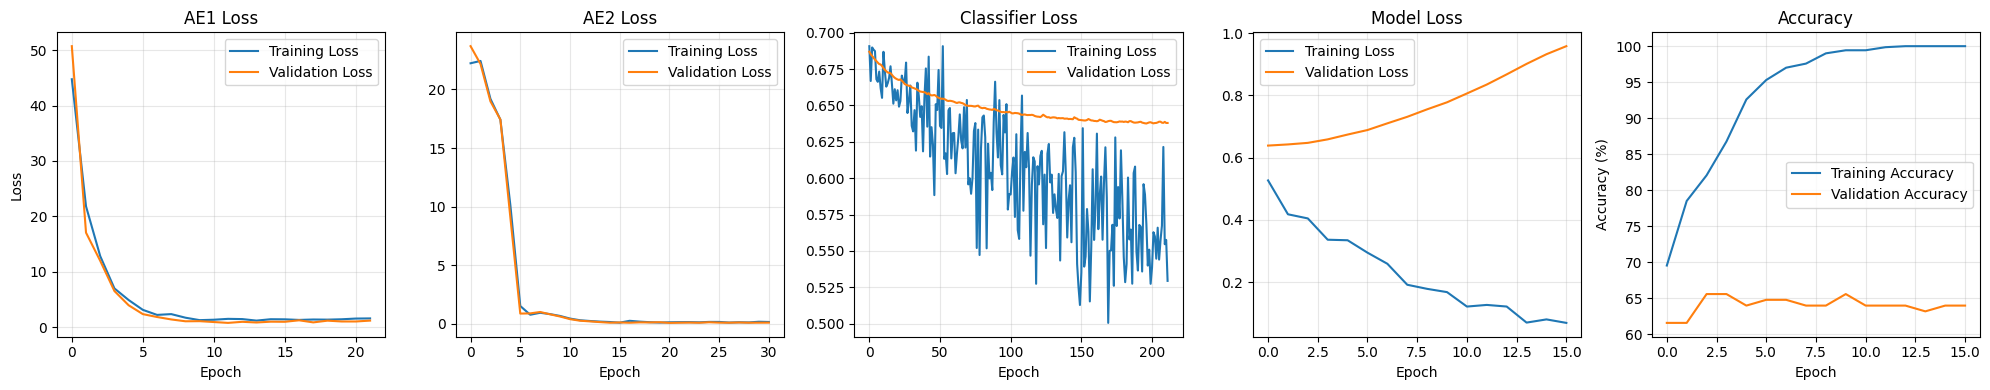

Testing Model
Fold 4 Results:
Accuracy: 62.32%
Sensitivity: 0.6264
Specificity: 0.6207
Precision: 0.5644
F1_Score: 0.5937
Confusion Matrix:
[[57 44]
 [34 72]]
Split 5


/usr/local/lib/python3.12/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


RFE selected 1000 features out of 6670
Total:  1035
Train:  703
Test:  207
Validation:  125
AE 1: Epoch 0, loss 50.2356, validation loss 52.7641
AE 1: Epoch 1, loss 30.9188, validation loss 26.6540
AE 1: Epoch 2, loss 20.6050, validation loss 13.7422
AE 1: Epoch 3, loss 6.7195, validation loss 6.6622
AE 1: Epoch 4, loss 5.4478, validation loss 4.3159
AE 1: Epoch 5, loss 3.5049, validation loss 2.9475
AE 1: Epoch 6, loss 2.2628, validation loss 1.9274
AE 1: Epoch 7, loss 2.2837, validation loss 1.3813
AE 1: Epoch 8, loss 1.5852, validation loss 1.1697
AE 1: Epoch 9, loss 1.6002, validation loss 1.0271
AE 1: Epoch 10, loss 1.3385, validation loss 0.9261
AE 1: Epoch 11, loss 1.3898, validation loss 0.8863
AE 1: Epoch 12, loss 1.7507, validation loss 0.7926
AE 1: Epoch 13, loss 1.1346, validation loss 0.8577
EarlyStopping counter: 1 out of 10
AE 1: Epoch 14, loss 1.5271, validation loss 0.9095
EarlyStopping counter: 2 out of 10
AE 1: Epoch 15, loss 1.9805, validation loss 0.9078
EarlyStopp

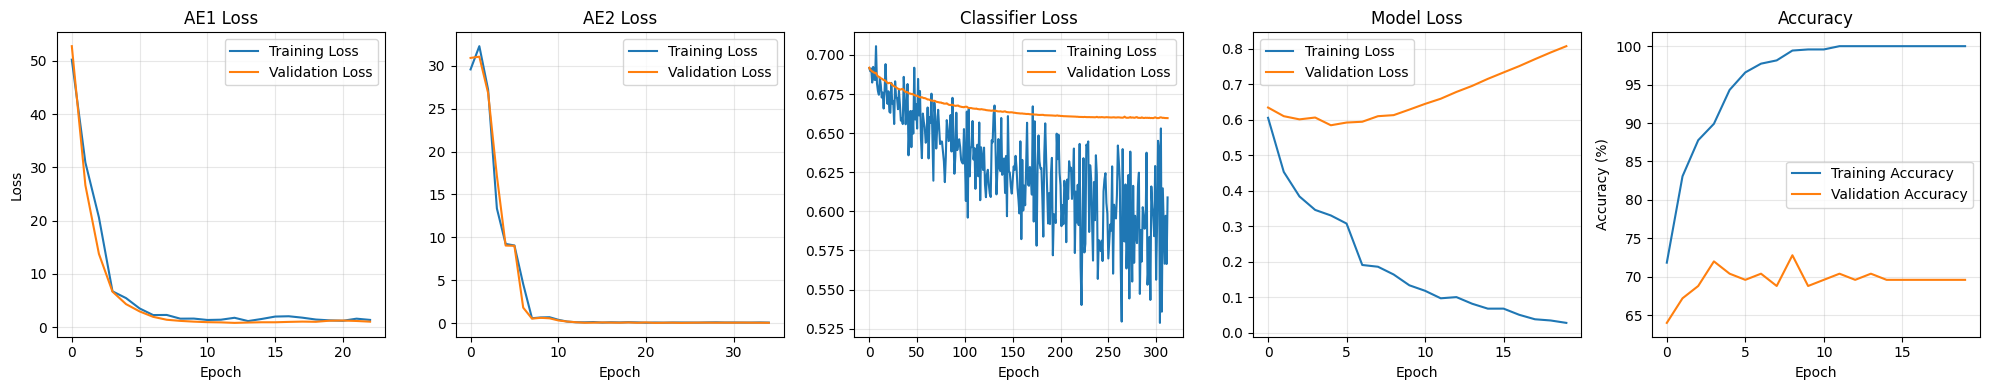

Testing Model
Fold 5 Results:
Accuracy: 63.77%
Sensitivity: 0.6383
Specificity: 0.6372
Precision: 0.5941
F1_Score: 0.6154
Confusion Matrix:
[[60 41]
 [34 72]]
Completed All Folds

FINAL CROSS-VALIDATION RESULTS (Mean ± Std)
Accuracy:    63.57% ± 1.24%
Sensitivity: 0.6320 ± 0.0143
Specificity: 0.6396 ± 0.0128
Precision:   0.6079 ± 0.0263
F1 Score:    0.6194 ± 0.0159

Average Confusion Matrix:
[[61.4 39.6]
 [35.8 70.2]]


In [10]:
print("verbose:", verbose)
print("train_model:", train_model)
print("save_model:", save_model)
print("Torch CUDA is available:", use_cuda)
# Set random seeds for reproducibility
seed = 2109459083
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if use_cuda:
  torch.cuda.manual_seed_all(seed)
# Main pipeline
pipeline = 'cpac'
data, labels_from_abide = get_data_from_abide(pipeline)
RFE_step = 20
print(f"Total samples loaded: {len(data)}")
print(f"Shape of raw data[0] (time points x ROIs): {data[0].shape}")
model, base_accuracy, train_dataloader, test_dataloader = train_and_eval_model(
  data, labels_from_abide, pipeline,
  verbose=verbose, train_model=train_model, save_model=save_model, rfe_step=RFE_step
)